In [1]:
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
from datetime import datetime

# Импорт базовых библиотек
import numpy as np
import pandas as pd

# Визуализация

import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from sklearn.model_selection import cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Метрики
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # для классификации

In [2]:
df = pd.read_csv('data/nba2k20-full.csv')
df.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   full_name    429 non-null    object
 1   rating       429 non-null    int64 
 2   jersey       429 non-null    object
 3   team         406 non-null    object
 4   position     429 non-null    object
 5   b_day        429 non-null    object
 6   height       429 non-null    object
 7   weight       429 non-null    object
 8   salary       429 non-null    object
 9   country      429 non-null    object
 10  draft_year   429 non-null    int64 
 11  draft_round  429 non-null    object
 12  draft_peak   429 non-null    object
 13  college      363 non-null    object
dtypes: int64(2), object(12)
memory usage: 47.0+ KB


In [4]:
def transform_data(data_frame):
    data_frame["salary_value"] = data_frame["salary"].transform(lambda x: float(x[1:]))
    data_frame["draft_round"] = data_frame["draft_round"].transform([lambda x: (-1) if x == "Undrafted" else int(x)])
    data_frame["draft_peak"] = data_frame["draft_peak"].transform([lambda x: (-1) if x == "Undrafted" else int(x)])
    data_frame["team"] = data_frame["team"].transform(lambda x: str(x))
    data_frame["b_day"] = data_frame["b_day"].transform(lambda x: parse(x))
    data_frame["age"] = data_frame["b_day"].transform(lambda x: relativedelta(datetime.today(), x).years)
    data_frame["weight_kg"] = data_frame["weight"].transform(lambda x: float(x[x.find("/")+1:x.find("kg")]))
    data_frame["height_mts"] = data_frame["height"].transform(lambda x: float(x[x.find("/")+1:]))
    data_frame["rating_lvl"] = data_frame["rating"].transform(lambda x: 0 if x < 75 else (1 if x < 85 else 2))
    return data_frame
    
df = transform_data(df)
df.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college,salary_value,age,weight_kg,height_mts,rating_lvl
0,LeBron James,97,#23,Los Angeles Lakers,F,1984-12-30,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN,37436858.0,36,113.4,2.06,2
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,1991-06-29,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State,32742000.0,30,102.1,2.01,2
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,1994-12-06,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN,25842697.0,26,109.8,2.11,2
3,Kevin Durant,96,#7,Brooklyn Nets,F,1988-09-29,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas,37199000.0,33,104.3,2.08,2
4,James Harden,96,#13,Houston Rockets,G,1989-08-26,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State,38199000.0,32,99.8,1.96,2


In [5]:
dfx = pd.DataFrame(df, columns=['salary_value', 'age', 'weight_kg', 'height_mts'])
X = dfx.to_numpy()
y = df["rating_lvl"].to_numpy()

dfx.head()

,salary_value,age,weight_kg,height_mts
0,37436858.0,36,113.4,2.06
1,32742000.0,30,102.1,2.01
2,25842697.0,26,109.8,2.11
3,37199000.0,33,104.3,2.08
4,38199000.0,32,99.8,1.96


(array([0, 1, 2], dtype=int64), array([191, 189,  49], dtype=int64))


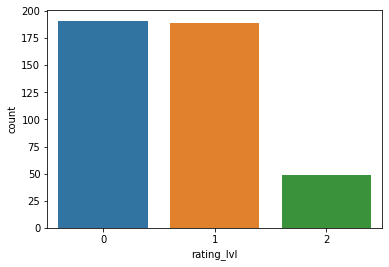

In [6]:
import seaborn as sns

print(np.unique(y, return_counts=True))
sns.countplot(x='rating_lvl', data=df);

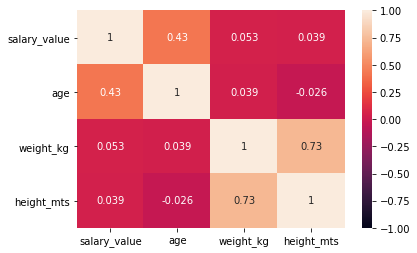

In [7]:
sns.heatmap(dfx.corr(), vmin=-1, vmax=1, annot=True);

salary_value: NormaltestResult(statistic=112.96035398868945, pvalue=2.9578135519485964e-25)
age: NormaltestResult(statistic=18.20144715141963, pvalue=0.00011158503904840153)
weight_kg: NormaltestResult(statistic=10.843417553875204, pvalue=0.004419588101514321)
height_mts: NormaltestResult(statistic=4.846177468074185, pvalue=0.08864738596500196)


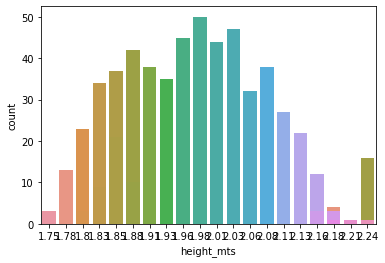

In [8]:
from scipy import stats

for col in dfx.columns:
    sns.countplot(x=col , data=df)
    print(col + ": " + str(stats.normaltest(dfx[col])))

In [9]:
scoring = make_scorer(precision_score, average='micro')

# Инициализируем алгоритмы с параметрами по-умолчанию
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

# Посчитаем метрику качества используя кросс-валидацию
knn_acc_score = cross_val_score(knn_clf, X, y, cv=7, scoring=scoring).mean()
svm_acc_score = cross_val_score(svm_clf, X, y, cv=7, scoring=scoring).mean()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7, scoring=scoring).mean()

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}. {leader_name}: {leader_score}')

Leaderboard:
1. SVC: 0.7320767545516356
2. KNN: 0.7017073354989801
3. Forest: 0.666729621515449
